# 第7章: 機械学習
本章では、Stanford Sentiment Treebank (SST) データセットを用い、評判分析器（ポジネガ分類器）を構築する。ここでは処理を簡略化するため、General Language Understanding Evaluation (GLUE) ベンチマークで配布されているSSTデータセットを用いる。

## 60. データの入手・整形
GLUEのウェブサイトからSST-2データセットを取得せよ。学習データ（train.tsv）と検証データ（dev.tsv）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [28]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('SST-2/train.tsv', sep='\t').to_numpy()
valid_data = pd.read_csv('SST-2/dev.tsv', sep='\t').to_numpy()

def count_label(data):
    num_neg, num_pos = 0, 0
    labels = data[:, 1]
    num_neg = np.sum(labels == 0)
    num_pos = np.sum(labels == 1)
    return num_neg, num_pos

# Obtain results
res_train = count_label(train_data)
res_valid = count_label(valid_data)

print(f"train:\tnum_neg: {res_train[0]}, num_pos: {res_train[1]}")
print(f"valid:\tnum_neg: {res_valid[0]}, num_pos: {res_valid[1]}")

train:	num_neg: 29780, num_pos: 37569
valid:	num_neg: 428, num_pos: 444


## 61. 特徴ベクトル
Bag of Words (BoW) に基づき、学習データ（train.tsv）および検証データ（dev.tsv）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、”too loud , too goofy”というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。

```python
{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}
```

各事例はテキスト、特徴ベクトル、ラベルを格納した辞書オブジェクトでまとめておく。例えば、先ほどの”too loud , too goofy”に対してラベル”0”（ネガティブ）が付与された事例は、以下のオブジェクトで表現される。

```python
{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}
```
学習データと検証データの各事例を上記のような辞書オブジェクトに変換したうえで、学習データと検証データのそれぞれを、辞書オブジェクトのリストとして表現せよ。さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。

In [30]:
def convert_to_dictionary(data):
    results = []

    for d in data:
        # Clear comma and period
        raw_d = d[0].replace('.', '').replace(',', '')

        curr_feature = {}
        tokens = raw_d.split()
        for t in tokens:
            curr_feature[t] = curr_feature.get(t, 0) + 1
        curr_dict = {'text': d[0], 'label': d[1], 'feature': curr_feature}

        results.append(curr_dict)
    
    return results

train_data_dicts = convert_to_dictionary(train_data)
valid_data_dicts = convert_to_dictionary(valid_data)

print(f"data_dicts_train[0]: {train_data_dicts[0]}")
print(f"data_dicts_valid[0]: {valid_data_dicts[0]}")


data_dicts_train[0]: {'text': 'hide new secretions from the parental units ', 'label': 0, 'feature': {'hide': 1, 'new': 1, 'secretions': 1, 'from': 1, 'the': 1, 'parental': 1, 'units': 1}}
data_dicts_valid[0]: {'text': "it 's a charming and often affecting journey . ", 'label': 1, 'feature': {'it': 1, "'s": 1, 'a': 1, 'charming': 1, 'and': 1, 'often': 1, 'affecting': 1, 'journey': 1}}


## 62. 学習
61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [32]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_features = [d['feature'] for d in train_data_dicts]
train_labels = [d['label'] for d in train_data_dicts]
valid_features = [d['feature'] for d in valid_data_dicts]
valid_labels = [d['label'] for d in valid_data_dicts]

# Obtain train features and valid features
vec = DictVectorizer(sparse=True)
X_train = vec.fit_transform(train_features)
X_valid = vec.transform(valid_features)

# Training
model = LogisticRegression()
model.fit(X_train, train_labels)


/gs/bs/tga-c-ird-lab/chen/miniconda/envs/nlp100-py310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## 63. 予測
学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。また、予測されたラベルが検証データで付与されていたラベルと一致しているか、確認せよ。

In [62]:
y_valid_preds = model.predict(X_valid)
print("valid acc:", np.mean(valid_preds == valid_labels))

valid acc: 0.8084862385321101


## 64. 条件付き確率
学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ポジネガ）に分類するときの条件付き確率を求めよ

In [45]:
x0_vec = X_valid[0]
probs = model.predict_proba(x0_vec)[0]
print(f"P(0|x0): {probs[0]}, P(1|x0): {probs[1]}")

P(0|x0): 0.0034914459052129976, P(1|x0): 0.996508554094787


## 65. テキストのポジネガの予測
与えられたテキストのポジネガを予測するプログラムを実装せよ。例えば、テキストとして”the worst movie I ‘ve ever seen”を与え、ロジスティック回帰モデルの予測結果を確認せよ。

In [63]:
target_text = "the worst movie I ‘ve ever seen"

def text_to_features(text):
    text_clean = text.replace('.', '').replace(',', '')
    tokens = text_clean.split()
    
    # Count the frequency of each token
    features = {}
    for t in tokens:
        features[t] = features.get(t, 0) + 1
    return features

x_target = vec.transform(text_to_features(target_text))
y_pred = model.predict(x_target)[0]

pred_res = "negative" if y_pred == 0 else "positive"
print(f"Prediction: {pred_res}, Prob: {model.predict_proba(text_feature)[0][y_pred]}")


Prediction: negative, Prob: 0.9672617554202129


## 66. 混同行列の作成
学習したロジスティック回帰モデルの検証データにおける混同行列（confusion matrix）を求めよ。

In [64]:
from sklearn.metrics import confusion_matrix

X_valid = vec.transform(valid_features)
y_valid_pred = model.predict(X_valid)

# confused matrix
confused_matrix = confusion_matrix(valid_labels, y_valid_pred)
print(confused_matrix)

[[333  95]
 [ 72 372]]


## 67. 精度の計測
学習したロジスティック回帰モデルの正解率、適合率、再現率、F1スコアを、学習データおよび検証データ上で計測せよ。

In [68]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_train_preds = model.predict(X_train)
y_valid_preds = model.predict(X_valid)

def print_result(name, preds, labels):
    acc = accuracy_score(preds, labels)
    prec = precision_score(preds, labels)
    recall = recall_score(preds, labels)
    f1 = f1_score(preds, labels)
    print(f"{name}_data\taccuracy: {acc}, precision: {prec}, recall: {recall}, f1: {f1}")

print_result("train", y_train_preds, train_labels)
print_result("valid", y_valid_preds, valid_labels)


train_data	accuracy: 0.9422263136794904, precision: 0.9548297798717027, recall: 0.9423632638049703, f1: 0.9485555629007735
valid_data	accuracy: 0.8084862385321101, precision: 0.8378378378378378, recall: 0.7965738758029979, f1: 0.8166849615806806


## 68. 特徴量の重みの確認
学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。

In [75]:
# Get features names
feature_names = vec.get_feature_names_out()
# Get weights of features
weights = model.coef_[0]

# Get indices corresponding to ascending weights
sorted_idx = np.argsort(weights)

# low 20 
low20_idx = sorted_idx[:20]
# high 20
high20_idx = sorted_idx[-20:][::-1]

# 3. 打印结果
print("——Top-20 Features——")
for idx in high20_idx:
    print(f"{feature_names[idx]} : {weights[idx]:.4f}")

print("\n——Low-20 Features——")
for idx in low20_idx:
    print(f"{feature_names[idx]} : {weights[idx]:.4f}")

——Top-20 Features——
refreshing : 3.4927
remarkable : 3.3824
powerful : 3.2488
hilarious : 3.1816
beautiful : 3.0294
wonderful : 2.9970
terrific : 2.8957
treat : 2.8940
prose : 2.8674
appealing : 2.8601
enjoyable : 2.7832
vividly : 2.7395
likable : 2.7211
charming : 2.6568
charmer : 2.6354
solid : 2.6167
miracle : 2.6067
intriguing : 2.5932
impressive : 2.5908
half-bad : 2.5716

——Low-20 Features——
lacking : -4.3565
worst : -4.0905
lacks : -4.0473
devoid : -3.7562
mess : -3.6157
failure : -3.6079
stupid : -3.3364
bore : -3.3325
flat : -3.2171
loses : -3.1975
waste : -3.1534
depressing : -3.1465
squanders : -3.0996
lack : -3.0602
pointless : -3.0231
none : -3.0205
lousy : -3.0002
poor : -2.9956
hardly : -2.9770
unfortunately : -2.9719


## 69. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Create 10 Cs.
Cs = np.logspace(-3, 3, 10)

accuracies = []
for C in Cs:
    model = LogisticRegression(C=C)
    model.fit(X_valid, valid_labels)
    
    # Compute accuracy
    acc = model.score(X_valid, valid_labels)
    accuracies.append(acc)

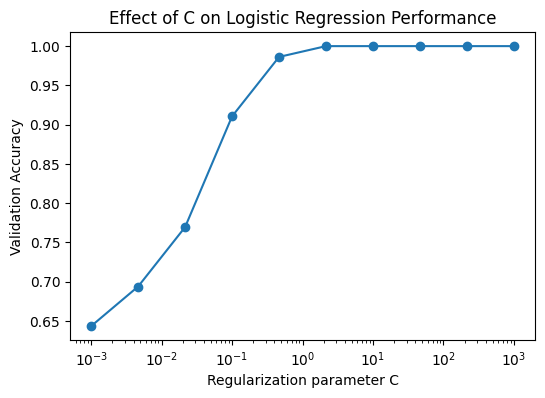

In [82]:
# Plot
plt.figure(figsize=(6,4))
plt.semilogx(Cs, accuracies, marker='o')
plt.xlabel('Regularization parameter C')
plt.ylabel('Validation Accuracy')
plt.title('Effect of C on Logistic Regression Performance')
plt.show()